In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
import tensorflow.keras as layers

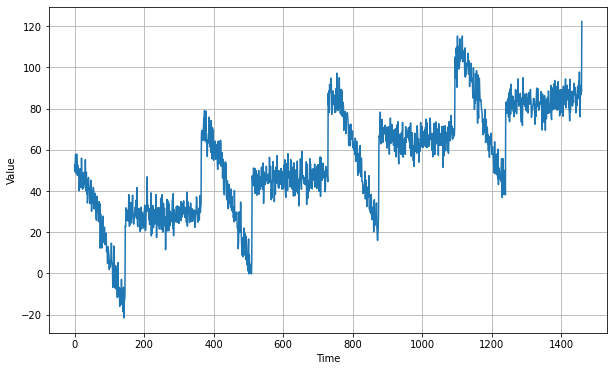

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    # Just an arbitrary pattern, you can change it if you wish
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    # repeat the same pattern at each period
    season_time=((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

def white_noise(time,noise_level,seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

amplitude=40
series=seasonality(time,period=365,amplitude=amplitude)

slope=0.05
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)

noise_level=5
noise=white_noise(time,noise_level,seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series);

In [4]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [5]:
def sequnetial_window_dataset(series,window_size):
    series=tf.expand_dims(series, axis=-1)
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=window_size,drop_remainder=True)
    dataset=dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset=dataset.map(lambda window: (window[:-1],window[1:]))
    return dataset.batch(1).prefetch(1)

In [6]:
for x_batch, y_batch in sequnetial_window_dataset(tf.range(10),3):
    print (x_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [10]:
import tensorflow.keras

In [11]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [21]:
# tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set=sequnetial_window_dataset(x_train,window_size)
#valid_set=sequnetial_window_dataset(x_valid,window_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(500,return_sequences=True, stateful=True,
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.SimpleRNN(500,return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200)
])
lr_schedule=keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/30))
reset_states=ResetStatesCallback()

optimizers=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=['mae'])

# model.fit(train_set,epochs=100,validation_data=valid_set)

history=model.fit(train_set,epochs=500,callbacks=[lr_schedule,reset_states])

Epoch 1/500
33/33 [==============================] - 9s 268ms/step - loss: 132.5141 - mae: 133.0139
Epoch 2/500
33/33 [==============================] - 7s 197ms/step - loss: 42.3595 - mae: 41.9656
Epoch 3/500
33/33 [==============================] - 7s 199ms/step - loss: 45.3316 - mae: 45.1088
Epoch 4/500
33/33 [==============================] - 7s 200ms/step - loss: 34.8128 - mae: 34.4307
Epoch 5/500
33/33 [==============================] - 7s 198ms/step - loss: 32.3068 - mae: 31.9876
Epoch 6/500
33/33 [==============================] - 7s 203ms/step - loss: 28.8283 - mae: 28.6328
Epoch 7/500
33/33 [==============================] - 7s 208ms/step - loss: 26.5254 - mae: 26.3705
Epoch 8/500
33/33 [==============================] - 7s 206ms/step - loss: 25.6158 - mae: 25.4843
Epoch 9/500
33/33 [==============================] - 7s 209ms/step - loss: 24.8284 - mae: 24.7169
Epoch 10/500
33/33 [==============================] - 7s 203ms/step - loss: 24.0083 - mae: 23.9222
Epoch 11/500
33/3

33/33 [==============================] - 9s 285ms/step - loss: 84.0756 - mae: 86.9418
Epoch 84/500
33/33 [==============================] - 9s 267ms/step - loss: 140.2658 - mae: 140.9498
Epoch 85/500
33/33 [==============================] - 9s 266ms/step - loss: 58.4244 - mae: 59.8006
Epoch 86/500
33/33 [==============================] - 10s 301ms/step - loss: 83.6969 - mae: 84.4964
Epoch 87/500
33/33 [==============================] - 9s 287ms/step - loss: 87.4503 - mae: 86.2976
Epoch 88/500
33/33 [==============================] - 10s 307ms/step - loss: 102.1481 - mae: 103.8791
Epoch 89/500
33/33 [==============================] - 9s 281ms/step - loss: 67.1845 - mae: 66.6484
Epoch 90/500
33/33 [==============================] - 9s 286ms/step - loss: 54.1343 - mae: 55.5855
Epoch 91/500
33/33 [==============================] - 9s 287ms/step - loss: 69.1558 - mae: 70.5210
Epoch 92/500
33/33 [==============================] - 9s 261ms/step - loss: 87.3430 - mae: 89.9423
Epoch 93/500
33/3

KeyboardInterrupt: 

In [15]:
model.reset_states()

rnn_forecast=model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast=rnn_forecast[0, split_time - 1:-1, 0]

In [17]:
rnn_forecast.shape

(461,)

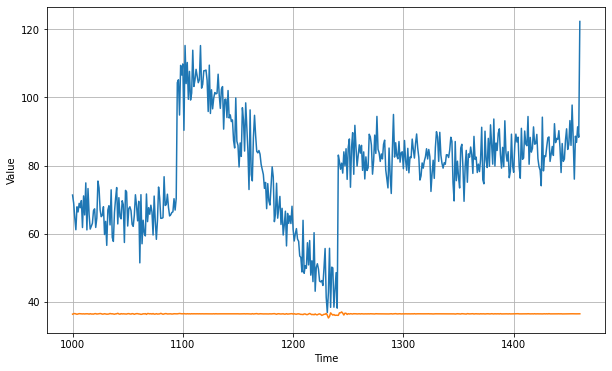

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid);
plot_series(time_valid, rnn_forecast);

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

41.96593